<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>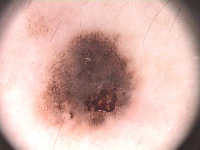</td><td>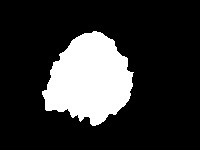</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=6cf6191a-8cc1-4319-abcf-5a450bd97f0b
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 100MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

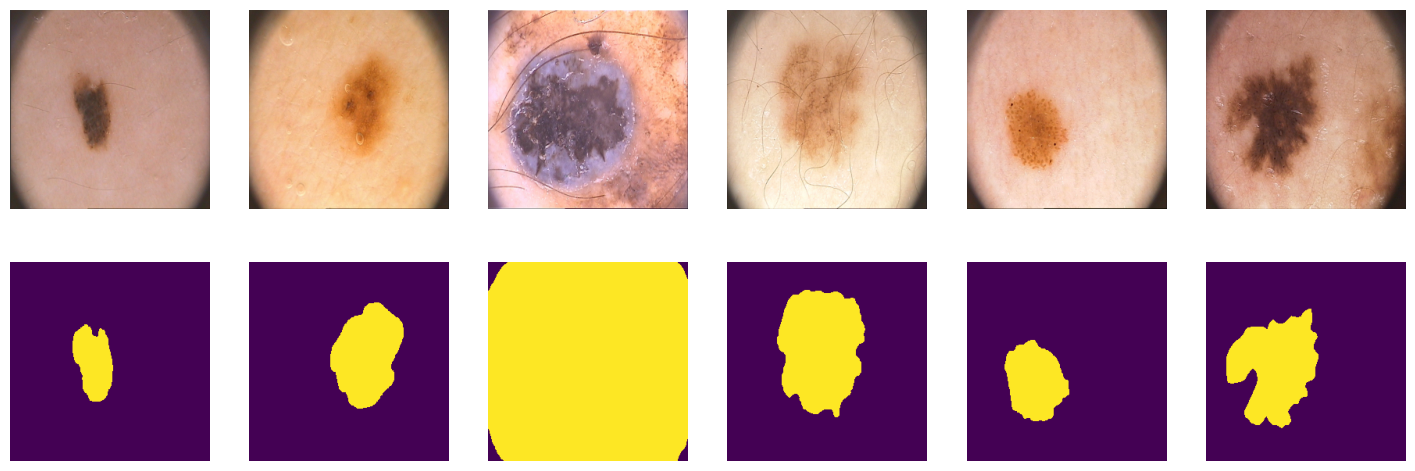

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.2 MB/s eta 0:00:00


In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**
 Здесь x = логиты, z = лейблы.
$$\mathcal \
\ L_{BCE} = z \cdot \left(-\log(\sigma(x))\right) + (1 - z) \cdot \left(-\log(1 - \sigma(x))\right)
$$

$$\mathcal
= z \cdot \left(-\log\left(\frac{1}{1 + e^{-x}}\right)\right) + (1 - z) \cdot \left(-\log\left(\frac{e^{-x}}{1 + e^{-x}}\right)\right)
\
$$

$$\mathcal
= z \cdot \log(1 + e^{-x}) + (1 - z) \cdot \left(-\log(e^{-x}) + \log(1 + e^{-x})\right)
\
$$

$$\mathcal
= z \cdot \log(1 + e^{-x}) + (1 - z) \cdot \left(x + \log(1 + e^{-x})\right)
\
$$
$$\mathcal
= x - x \cdot z + \log(1 + e^{-x})
\
$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_loss(y_pred, y_real):
  return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).sum()

def bce_true(y_pred, y_real):
  return -(y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred))).sum()

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 3.4771573543548584
BCE loss честно посчитанный                = 3.4771571159362793
BCE loss from torch bce_torch              = 3.4771571159362793
BCE loss from torch with logits bce_torch  = 3.4771571159362793


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 17.83916473388672
BCE loss честно посчитанный               = 17.83916473388672
BCE loss from torch bce_torch             = 17.83916473388672
BCE loss from torch with logits bce_torch = 17.83916473388672


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 6.03MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 4.55MB/s]
Download completed


In [21]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

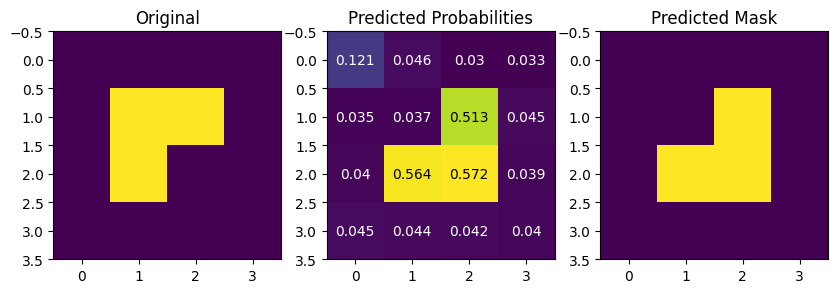

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

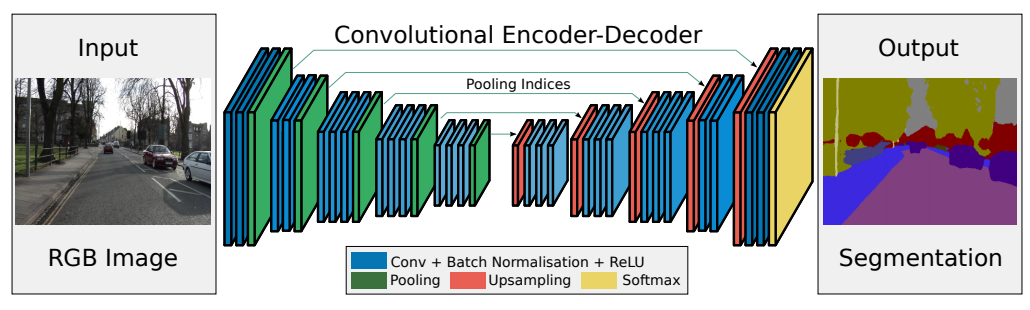

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import pandas as pd
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [25]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 93.8MB/s]


In [26]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [27]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) #добавляем MaxPool с индексами для последующего Unpooling

    # Обратите внимание: на вход метод forward() получает карту признаков (х),
    # а возвращает карту признаков и индексы для последующего Unpooling
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices


По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [28]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size=3, padding=1, is_final=False):
        super(DecoderBlock, self).__init__()

        self.maxunpooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()

        self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                     kernel_size=kernel_size, padding=padding))
        self.layers.append(nn.BatchNorm2d(in_channels))
        self.layers.append(nn.ReLU(inplace=True))

        for i in range(depth - 2):
            self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                         kernel_size=kernel_size, padding=padding))
            self.layers.append(nn.BatchNorm2d(in_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=kernel_size, padding=padding))

        if not is_final:
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

    def forward(self, x, indices):
        x = self.maxunpooling(x, indices)

        for layer in self.layers:
            x = layer(x)

        return x

Соединим блоки энкодера и декодера в модель SegNet:

In [29]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, num_features=64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)
        self.encoder2 = EncoderBlock(num_features * 2, num_features * 4, depth=3)
        self.encoder3 = EncoderBlock(num_features * 4, num_features * 8, depth=3)

        # Encoder bottleneck
        self.encoder4 = EncoderBlock(num_features * 8, num_features * 8, depth=3)

        # Decoder bottleneck
        self.decoder4 = DecoderBlock(num_features * 8, num_features * 8, depth=3, is_final=False)

        # Decoder
        self.decoder3 = DecoderBlock(num_features * 8, num_features * 4, depth=3, is_final=False)
        self.decoder2 = DecoderBlock(num_features * 4, num_features * 2, depth=3, is_final=False)
        self.decoder1 = DecoderBlock(num_features * 2, num_features, depth=2, is_final=False)

        self.decoder0 = DecoderBlock(num_features, out_channels, depth=2, is_final=True)

    def forward(self, x):
        # Encoder
        x, indices0 = self.encoder0(x)
        x, indices1 = self.encoder1(x)
        x, indices2 = self.encoder2(x)
        x, indices3 = self.encoder3(x)
        x, indices4 = self.encoder4(x)

        # Decoder
        x = self.decoder4(x, indices4)
        x = self.decoder3(x, indices3)
        x = self.decoder2(x, indices2)
        x = self.decoder1(x, indices1)
        output = self.decoder0(x, indices0)

        return output

## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [30]:
from tqdm.notebook import tqdm

In [31]:
segnet_model = SegNet(in_channels=3, out_channels=1).to(device)

optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e4)
loss_fn = nn.BCEWithLogitsLoss()

In [32]:
def train(model, train_dataloader, valid_dataloader, optimizer, loss_func, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, masks in tqdm(valid_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = loss_func(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(valid_dataloader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [33]:
train(segnet_model, train_dataloader, valid_dataloader, optimizer, loss_fn, num_epochs=20, device=device)

Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.6815, Validation Loss: 0.6861


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.5942, Validation Loss: 0.6629


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.5491, Validation Loss: 0.6295


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.5038, Validation Loss: 0.6231


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.4392, Validation Loss: 0.6500


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.3600, Validation Loss: 0.6590


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.3004, Validation Loss: 0.7160


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.2895, Validation Loss: 0.4725


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.3227, Validation Loss: 0.3752


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.2404, Validation Loss: 0.2856


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.2151, Validation Loss: 0.3352


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.2334, Validation Loss: 0.2992


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.2421, Validation Loss: 0.3989


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.2089, Validation Loss: 0.4790


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.2210, Validation Loss: 0.2816


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.1990, Validation Loss: 0.2345


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.1978, Validation Loss: 0.2584


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.2025, Validation Loss: 0.2259


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.1994, Validation Loss: 0.2660


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.2030, Validation Loss: 0.4661


## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [34]:
def test(model, test_dataloader, device, iou):
  model.eval()
  iou.reset()
  iou_scores = []
  with torch.no_grad():
    for images, masks in tqdm(test_dataloader):

      images, masks = images.to(device), masks.to(device)

      outputs = model(images)

      predicted_masks = (outputs > 0.5).float()

      iou_score = iou(predicted_masks, masks)
      iou_scores.append(iou_score.item())


  mean_iou_score = sum(iou_scores) / len(iou_scores)
  print(f"Mean IoU Score: {mean_iou_score:.4f}")
  return mean_iou_score

In [35]:
test_score = test(segnet_model, test_dataloader, device, iou_score)

  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.3711


# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [36]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5, eps: float = 1e-8):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    TP = (preds * labels).sum(dim=(1,2,3))
    FP = (preds * (1 - labels)).sum(dim=(1,2,3))
    FN = ((1 - preds) * labels).sum(dim=(1, 2, 3))

    score = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    return score


Проверим на корректность функцию dice_score:

In [37]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].to(int))

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


tensor(0.6667, device='cuda:0')

In [38]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

tensor([0.6667], device='cuda:0')

In [39]:
assert dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [40]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor, eps: float = 1e-8):

    '''
    Это лосс.
    '''
    probs = torch.sigmoid(logits)

    TP = (probs * labels).sum(dim=(1,2,3))
    FP = (probs * (1 - labels)).sum(dim=(1,2,3))
    FN = ((1 - probs) * labels).sum(dim=(1, 2, 3))

    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    loss = 1 - dice

    return loss.mean()

Проверка на корректность:

In [41]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00


In [42]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [43]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [44]:
def focal_loss(inputs, targets, eps=1e-8, gamma=2.0, reduction="mean"):
    probs = torch.sigmoid(inputs)
    pt = probs * targets + (1 - probs) * (1 - targets)
    focal_weight = (1 - pt) ** gamma

    bce = targets * torch.log(probs + eps) + \
          (1 - targets) * torch.log(1 - probs + eps)

    loss = -focal_weight * bce

    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

Проверка корректности функции:

In [45]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='mean')

tensor(0.2260, device='cuda:0')

In [46]:
focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0, reduction='mean')

tensor(0.2260, device='cuda:0')

In [47]:
assert torch.allclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'), focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2, reduction='sum'), rtol=1e-4, atol=1e-6)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [48]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-8, reduction="mean"):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = eps
        self.reduction = reduction

    def forward(self, y_pred, y_real):
        y_pred = torch.sigmoid(y_pred)

        TP = (y_pred * y_real).sum(dim=(1,2,3))
        FP = (y_pred * (1 - y_real)).sum(dim=(1,2,3))
        FN = ((1 - y_pred) * y_real).sum(dim=(1,2,3))

        tversky_index = TP / (TP + self.alpha * FP + self.beta * FN + self.eps)
        tversky_loss = 1 - tversky_index

        if self.reduction == "mean":
            return tversky_loss.mean()
        elif self.reduction == "sum":
            return tversky_loss.sum()
        else:
            return tversky_loss


## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [49]:
num_epochs = 20
lr = 1e-4

In [50]:
print("Training with Focal Loss")
segnet_model = SegNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=lr)
start_time = time()
train(segnet_model, train_dataloader, valid_dataloader, optimizer, focal_loss, num_epochs, device)
end_time = time()
time_focal = end_time - start_time
test_focal = test(segnet_model, test_dataloader, device, iou_score)

Training with Focal Loss


Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.1821, Validation Loss: 0.1735


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.1651, Validation Loss: 0.1717


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.1360, Validation Loss: 0.1673


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.1067, Validation Loss: 0.1603


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.0851, Validation Loss: 0.1608


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.0687, Validation Loss: 0.1741


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.0586, Validation Loss: 0.2000


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.0611, Validation Loss: 0.2376


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.0565, Validation Loss: 0.1751


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.0462, Validation Loss: 0.0692


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.0404, Validation Loss: 0.0930


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.0369, Validation Loss: 0.0843


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.0379, Validation Loss: 0.0598


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.0503, Validation Loss: 0.0521


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.0373, Validation Loss: 0.0551


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.0548, Validation Loss: 0.0487


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.0365, Validation Loss: 0.0494


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.0335, Validation Loss: 0.0472


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.0397, Validation Loss: 0.0433


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.0335, Validation Loss: 0.0464


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.7630


In [51]:
print("Training with Dice Loss")
segnet_model = SegNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=lr)
start_time = time()
train(segnet_model, train_dataloader, valid_dataloader, optimizer, dice_loss, num_epochs, device)
end_time = time()
time_dice = end_time - start_time
test_dice = test(segnet_model, test_dataloader, device, iou_score)

Training with Dice Loss


Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.6224, Validation Loss: 0.6464


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.5541, Validation Loss: 0.6480


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.5146, Validation Loss: 0.6519


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.4767, Validation Loss: 0.6588


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.4491, Validation Loss: 0.6686


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.4264, Validation Loss: 0.6823


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.4164, Validation Loss: 0.6976


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.3959, Validation Loss: 0.6673


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.3756, Validation Loss: 0.5666


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.3610, Validation Loss: 0.4357


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.3418, Validation Loss: 0.3671


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.3354, Validation Loss: 0.3223


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.3268, Validation Loss: 0.3488


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.3187, Validation Loss: 0.2924


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.3050, Validation Loss: 0.2846


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.2881, Validation Loss: 0.2604


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.2833, Validation Loss: 0.2541


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.2671, Validation Loss: 0.2519


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.2566, Validation Loss: 0.2390


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.2402, Validation Loss: 0.2344


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.8230


In [52]:
print("Training with Tversky Loss")
segnet_model = SegNet(in_channels=3, out_channels=1).to(device)
tversky_loss_fn = TverskyLoss()
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=lr)
start_time = time()
train(segnet_model, train_dataloader, valid_dataloader, optimizer, tversky_loss_fn, num_epochs, device)
end_time = time()
time_tversky = end_time - start_time
test_tversky = test(segnet_model, test_dataloader, device, iou_score)

Training with Tversky Loss


Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.6603, Validation Loss: 0.6450


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.6252, Validation Loss: 0.6458


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.5597, Validation Loss: 0.6487


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.5097, Validation Loss: 0.6557


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.4653, Validation Loss: 0.6702


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.4226, Validation Loss: 0.6934


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.3891, Validation Loss: 0.7287


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.3688, Validation Loss: 0.6680


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.3504, Validation Loss: 0.3352


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.3290, Validation Loss: 0.2909


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.3070, Validation Loss: 0.3076


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.2934, Validation Loss: 0.2600


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.2761, Validation Loss: 0.2551


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.2684, Validation Loss: 0.2554


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.2482, Validation Loss: 0.2413


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.2412, Validation Loss: 0.2386


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.2267, Validation Loss: 0.2918


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.2215, Validation Loss: 0.2750


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.2295, Validation Loss: 0.2121


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.2080, Validation Loss: 0.2095


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.8334


In [53]:
results = {
    "Loss Function": ["Focal Loss", "Dice Loss", "Tversky Loss"],
    "Training Time (seconds)": [time_focal, time_dice, time_tversky],
    "Test IoU Score": [test_focal, test_dice, test_tversky]
}

results_segnet = pd.DataFrame(results)

print(results_segnet)

  Loss Function  Training Time (seconds)  Test IoU Score
0    Focal Loss               104.832573        0.763027
1     Dice Loss               103.782211        0.823033
2  Tversky Loss               103.690862        0.833443


Модель быстрее сходится при Tversky Loss, но при этом остальные лоссы сходятся приблизительно за это же время.
Модель выдала лучшую метрику при Tversky Loss.

# Задание: Новая модель!

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

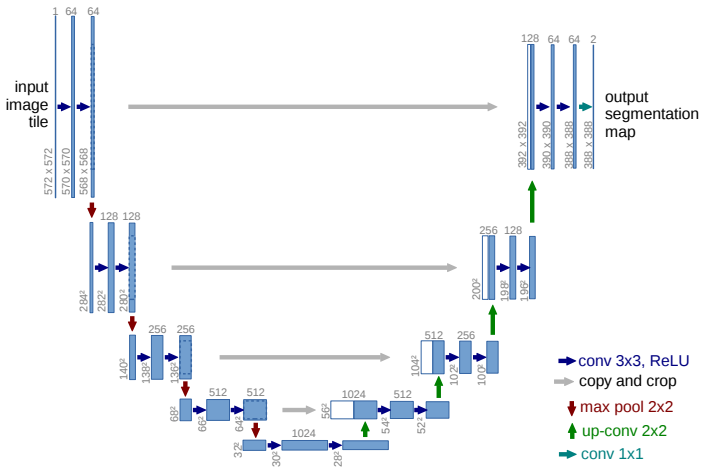

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [54]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [55]:
import torch
import torch.nn as nn


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2,
                                     kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_class=1, in_channels=3):
        super().__init__()

        # Encoder
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        # Bottleneck
        self.bottle_neck = DoubleConv(512, 1024)

        # Decoder
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=n_class, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [56]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [57]:
num_epochs = 20
lr = 1e-3

In [58]:
print("Training with Focal Loss")
unet_model = UNet(in_channels=3).to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr)
start_time = time()
train(unet_model, train_dataloader, valid_dataloader, optimizer, focal_loss, num_epochs, device)
end_time = time()
time_focal = end_time - start_time
test_focal = test(unet_model, test_dataloader, device, iou_score)

Training with Focal Loss


Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.1652, Validation Loss: 0.1467


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.1484, Validation Loss: 0.1439


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.1420, Validation Loss: 0.1349


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.1342, Validation Loss: 0.1267


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.1259, Validation Loss: 0.1158


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.1167, Validation Loss: 0.1089


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.1104, Validation Loss: 0.1043


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.1087, Validation Loss: 0.1130


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.1094, Validation Loss: 0.1004


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.1116, Validation Loss: 0.1005


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.1071, Validation Loss: 0.0978


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.1014, Validation Loss: 0.0927


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.0916, Validation Loss: 0.0826


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.0858, Validation Loss: 0.0834


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.0862, Validation Loss: 0.0843


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.0834, Validation Loss: 0.0818


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.0850, Validation Loss: 0.0800


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.0823, Validation Loss: 0.0798


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.0838, Validation Loss: 0.0830


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.0865, Validation Loss: 0.0860


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.6090


In [59]:
print("Training with Dice Loss")
unet_model = UNet(in_channels=3).to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr)
start_time = time()
train(unet_model, train_dataloader, valid_dataloader, optimizer, dice_loss, num_epochs, device)
end_time = time()
time_dice = end_time - start_time
test_dice = test(unet_model, test_dataloader, device, iou_score)

Training with Dice Loss


Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.6541, Validation Loss: 0.6030


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.5803, Validation Loss: 0.5513


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.5691, Validation Loss: 0.5513


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.5685, Validation Loss: 0.5513


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.3447


In [60]:
print("Training with Tversky Loss")
unet_model = UNet(in_channels=3).to(device)
tversky_loss_fn = TverskyLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr)
start_time = time()
train(unet_model, train_dataloader, valid_dataloader, optimizer, tversky_loss_fn, num_epochs, device)
end_time = time()
time_tversky = end_time - start_time
test_tversky = test(unet_model, test_dataloader, device, iou_score)

Training with Tversky Loss


Epoch 1/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.6591, Validation Loss: 0.6136


Epoch 2/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.5833, Validation Loss: 0.5513


Epoch 3/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 4/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 5/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 6/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 7/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 8/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 9/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 10/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 11/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 12/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 13/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 14/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 15/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 16/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 17/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 18/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 19/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.5685, Validation Loss: 0.5513


Epoch 20/20 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.5685, Validation Loss: 0.5513


  0%|          | 0/2 [00:00<?, ?it/s]

Mean IoU Score: 0.3447


In [61]:
results = {
    "Loss Function": ["Focal Loss", "Dice Loss", "Tversky Loss"],
    "Training Time (seconds)": [time_focal, time_dice, time_tversky],
    "Test IoU Score": [test_focal, test_dice, test_tversky]
}

results_unet = pd.DataFrame(results)

print(results_unet)

  Loss Function  Training Time (seconds)  Test IoU Score
0    Focal Loss               110.962697        0.608997
1     Dice Loss               109.002967        0.344700
2  Tversky Loss               109.125888        0.344700


In [62]:
results_unet_df = pd.DataFrame(results_unet)
results_segnet_df = pd.DataFrame(results_segnet)

combined_results = pd.concat(
    [
        results_unet_df.assign(Model="UNet"),
        results_segnet_df.assign(Model="SegNet")
    ],
    ignore_index=True
)

print(combined_results)

  Loss Function  Training Time (seconds)  Test IoU Score   Model
0    Focal Loss               110.962697        0.608997    UNet
1     Dice Loss               109.002967        0.344700    UNet
2  Tversky Loss               109.125888        0.344700    UNet
3    Focal Loss               104.832573        0.763027  SegNet
4     Dice Loss               103.782211        0.823033  SegNet
5  Tversky Loss               103.690862        0.833443  SegNet


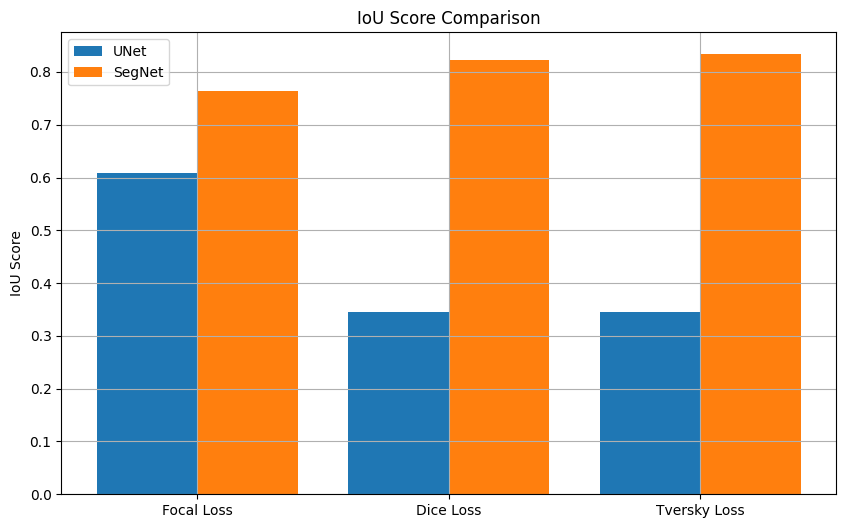

In [64]:
loss_names = results_unet["Loss Function"]
unet_iou   = results_unet["Test IoU Score"]
segnet_iou = results_segnet["Test IoU Score"]

x = np.arange(len(loss_names))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - bar_width / 2, unet_iou,   width=bar_width, label="UNet")
ax.bar(x + bar_width / 2, segnet_iou, width=bar_width, label="SegNet")

ax.set_xticks(x)
ax.set_xticklabels(loss_names)
ax.set_ylabel("IoU Score")
ax.set_title("IoU Score Comparison")
ax.legend()
ax.grid(True)

plt.show()

Лучшая модель SegNet c Dice Loss, она показывает значение IoU 0.8176. Модель SegNet с Tversky Loss показывает похожие результаты.

SegNet чуть быстрее обучается, чем UNet